# Lecture 5 Part 2: Advanced Financial Analysis - Tesla (TSLA)

**Continued from Part 1**
In this part, we cover Liquidity, Efficiency, Returns, and EVA.


In [1]:
# Setup for Part 2
import os
import pandas as pd
import yfinance as yf

USE_LOCAL_DATA = False
DATA_DIR = 'data'


def load_local_backup(data_dir=DATA_DIR):
    income_stmt = pd.read_excel(os.path.join(data_dir, 'tesla_income_stmt.xlsx'), index_col=0)
    balance_sheet = pd.read_excel(os.path.join(data_dir, 'tesla_balance_sheet.xlsx'), index_col=0)
    cash_flow = pd.read_excel(os.path.join(data_dir, 'tesla_cash_flow.xlsx'), index_col=0)
    return income_stmt, balance_sheet, cash_flow


def ensure_datetime_index(df):
    if isinstance(df.index, pd.DatetimeIndex):
        return df
    if df.index.dtype == 'object':
        df = df.copy()
        df.index = pd.to_datetime(df.index, errors='coerce')
    return df


def try_filter_from_date(df, start_date):
    if not isinstance(df.index, pd.DatetimeIndex):
        print('Warning: index is not datetime-like; skipping date filter for this table.')
        return df
    filtered = df[df.index >= pd.Timestamp(start_date)]
    if filtered.empty and not df.empty:
        print('Warning: filtered table is empty; using unfiltered data.')
        return df
    return filtered


income_stmt = balance_sheet = cash_flow = None
loaded_local = False

if USE_LOCAL_DATA and os.path.exists(DATA_DIR):
    try:
        income_stmt, balance_sheet, cash_flow = load_local_backup()
        loaded_local = True
        print('Loaded local Excel backup.')
    except Exception as e:
        print(f'Error loading local data: {e}, falling back to yfinance.')
        loaded_local = False

if not loaded_local:
    try:
        ticker = yf.Ticker('TSLA')
        income_stmt = ticker.financials.transpose()
        balance_sheet = ticker.balance_sheet.transpose()
        cash_flow = ticker.cashflow.transpose()

        income_stmt = ensure_datetime_index(income_stmt)
        balance_sheet = ensure_datetime_index(balance_sheet)
        cash_flow = ensure_datetime_index(cash_flow)

    except Exception as e:
        print(f'Error fetching data from yfinance ({type(e).__name__}): {e}')
        income_stmt = balance_sheet = cash_flow = pd.DataFrame()

    if (
        income_stmt.empty
        or balance_sheet.empty
        or cash_flow.empty
        or not isinstance(income_stmt.index, pd.DatetimeIndex)
        or not isinstance(balance_sheet.index, pd.DatetimeIndex)
        or not isinstance(cash_flow.index, pd.DatetimeIndex)
    ):
        backup_path = os.path.join(DATA_DIR, 'tesla_income_stmt.xlsx')
        if os.path.exists(backup_path):
            print('Falling back to local Excel backup in ./data ...')
            income_stmt, balance_sheet, cash_flow = load_local_backup()
        else:
            raise RuntimeError('No valid financial statement data available (yfinance failed and no local backup found).')

income_stmt = ensure_datetime_index(income_stmt)
balance_sheet = ensure_datetime_index(balance_sheet)
cash_flow = ensure_datetime_index(cash_flow)

# [FILTER] Remove 2021 Data as requested
FILTER_START_DATE = '2022-01-01'
print(f"Filtering data to include only records on or after {FILTER_START_DATE}...")

income_stmt = try_filter_from_date(income_stmt, FILTER_START_DATE)
balance_sheet = try_filter_from_date(balance_sheet, FILTER_START_DATE)
cash_flow = try_filter_from_date(cash_flow, FILTER_START_DATE)

latest_date = balance_sheet.index[0]
revenue = income_stmt['Total Revenue']
net_income = income_stmt['Net Income']
cost_of_revenue = income_stmt['Cost Of Revenue']
total_assets = balance_sheet['Total Assets']
print('Part 2 Environment Ready.')


Falling back to local Excel backup in ./data ...


Filtering data to include only records on or after 2022-01-01...
Part 2 Environment Ready.


In [2]:
# [SETUP] Define Visualization Function (Run this first, call it later)
def plot_trend():
    print('Generating Trend Analysis Charts... (This may take a moment)')

    import os
    import matplotlib.pyplot as plt
    import pandas as pd
    import yfinance as yf
    import seaborn as sns

    # --- 1. Settings & Quarterly Data Fetching ---
    ticker = 'TSLA'
    print(f"Fetching data for {ticker}...")

    data_dir = 'data'
    fin_path = os.path.join(data_dir, 'tesla_quarterly_financials.xlsx')
    bs_path = os.path.join(data_dir, 'tesla_quarterly_balance.xlsx')
    cf_path = os.path.join(data_dir, 'tesla_quarterly_cashflow.xlsx')

    q_fin = q_bs = q_cf = None

    if os.path.exists(fin_path) and os.path.exists(bs_path) and os.path.exists(cf_path):
        q_fin = pd.read_excel(fin_path, index_col=0)
        q_bs = pd.read_excel(bs_path, index_col=0)
        q_cf = pd.read_excel(cf_path, index_col=0)

        q_fin.index = pd.to_datetime(q_fin.index)
        q_bs.index = pd.to_datetime(q_bs.index)
        q_cf.index = pd.to_datetime(q_cf.index)

        q_fin = q_fin.sort_index()
        q_bs = q_bs.sort_index()
        q_cf = q_cf.sort_index()

    else:
        t = yf.Ticker(ticker)
        q_fin = t.quarterly_financials.transpose()
        q_bs = t.quarterly_balance_sheet.transpose()
        q_cf = t.quarterly_cashflow.transpose()

    # Merge Quarterly Data
    merged_df = q_fin.join(q_bs, lsuffix='_fin', rsuffix='_bs', how='outer')
    merged_df = merged_df.join(q_cf, rsuffix='_cf', how='outer')
    merged_df.index = pd.to_datetime(merged_df.index)
    merged_df = merged_df.sort_index()

    # Helper
    def get_val(row, col_list):
        for col in col_list:
            if col in row and not pd.isna(row[col]):
                return row[col]
        return 0

    # --- 2. Calculate Ratios (Monthly Interpolated) ---
    results = []
    for date, row in merged_df.iterrows():
        if date.year < 2023:
            continue
        try:
            rev = get_val(row, ['Total Revenue', 'Total Revenue_fin'])
            gross_profit = get_val(row, ['Gross Profit', 'Gross Profit_fin'])
            op_income = get_val(row, ['Operating Income', 'Operating Income_fin'])
            net_income = get_val(row, ['Net Income', 'Net Income_fin'])

            assets = get_val(row, ['Total Assets', 'Total Assets_bs'])
            equity = get_val(row, ['Stockholders Equity', 'Stockholders Equity_bs'])
            curr_assets = get_val(row, ['Current Assets', 'Current Assets_bs'])
            curr_liab = get_val(row, ['Current Liabilities', 'Current Liabilities_bs'])
            inventory = get_val(row, ['Inventory', 'Inventory_bs'])
            cash = get_val(row, ['Cash And Cash Equivalents', 'Cash And Cash Equivalents_bs'])
            debt = get_val(row, ['Total Debt', 'Total Debt_bs'])

            gross_margin = gross_profit / rev if rev else None
            op_margin = op_income / rev if rev else None
            net_margin = net_income / rev if rev else None

            curr_ratio = curr_assets / curr_liab if curr_liab else None
            quick_ratio = (curr_assets - inventory) / curr_liab if curr_liab else None
            cash_ratio = cash / curr_liab if curr_liab else None

            inv_turnover = get_val(row, ['Cost Of Revenue']) / inventory if inventory else None
            asset_turnover = rev / assets if assets else None

            roa = net_income / assets if assets else None
            roe = net_income / equity if equity else None

            nopat = op_income * 0.8
            invested = debt + equity
            roic = nopat / invested if invested else None

            ebit = op_income
            cap_emp = assets - curr_liab
            roce = ebit / cap_emp if cap_emp else None

            results.append(
                {
                    'Date': date,
                    'Gross Margin': gross_margin,
                    'Operating Margin': op_margin,
                    'Net Margin': net_margin,
                    'Current Ratio': curr_ratio,
                    'Quick Ratio': quick_ratio,
                    'Cash Ratio': cash_ratio,
                    'Inventory Turnover': inv_turnover,
                    'Asset Turnover': asset_turnover,
                    'ROA': roa,
                    'ROE': roe,
                    'ROIC': roic,
                    'ROCE': roce,
                }
            )
        except Exception:
            pass

    df_q = pd.DataFrame(results).set_index('Date')
    df_monthly = df_q.resample('M').interpolate(method='linear')
    plot_start = pd.Timestamp('2024-01-01')
    plot_end = pd.Timestamp('2025-12-31')
    df_plot = df_monthly[(df_monthly.index >= plot_start) & (df_monthly.index <= plot_end)]

    print(f"Plotting Monthly Ratio Data Points: {len(df_plot)}")

    # --- 3. Visualization (Monthly Ratios Grid) ---
    if not df_plot.empty:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(
            'Tesla Financial Metrics (Monthly Interpolated: 2024-2025 (or Latest Available))',
            fontsize=16,
        )

        def plot_category(ax, title, metrics, is_pct=True):
            for m in metrics:
                if m in df_plot.columns:
                    ax.plot(df_plot.index, df_plot[m], marker='o', markersize=4, label=m, linewidth=2)
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
            import matplotlib.dates as mdates
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

            if is_pct:
                ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

        plot_category(axes[0, 0], 'Profitability Trends', ['Gross Margin', 'Operating Margin', 'Net Margin'])
        plot_category(axes[0, 1], 'Liquidity Trends', ['Current Ratio', 'Quick Ratio', 'Cash Ratio'], is_pct=False)
        plot_category(axes[1, 0], 'Efficiency Trends', ['Inventory Turnover', 'Asset Turnover'], is_pct=False)
        plot_category(axes[1, 1], 'Return Metrics', ['ROA', 'ROE', 'ROIC', 'ROCE'])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    print('Visualization Complete.')


## Step 3: Profitability Analysis

Profitability analysis answers the question: "**How capable is this company of generating profit relative to its revenue or costs?**"

We will calculate three core metrics:

### 1. Gross Margin
Reflects the profitability of the product itself.

$$ \text{Gross Margin} = \frac{\text{Gross Profit}}{\text{Total Revenue}} $$

### 2. Operating Profit Margin
Reflects the operating efficiency of the company's core business (before interest and taxes).

$$ \text{Operating Margin} = \frac{\text{Operating Income}}{\text{Total Revenue}} $$

### 3. Net Profit Margin
Reflects the final profit remaining for shareholders after deducting all expenses.

$$ \text{Net Profit Margin} = \frac{\text{Net Income}}{\text{Total Revenue}} $$

In [3]:
# Extract key data from Income Statement
# Note: yfinance column names are standard English accounting terms

revenue = income_stmt['Total Revenue']
gross_profit = income_stmt['Gross Profit']
operating_income = income_stmt['Operating Income']
net_income = income_stmt['Net Income']

# Calculate Ratios
gross_margin = gross_profit / revenue
operating_margin = operating_income / revenue
net_margin = net_income / revenue

# Combine results into a DataFrame for viewing
profitability_df = pd.DataFrame({
    'Total Revenue': revenue,
    'Gross Margin': gross_margin,
    'Operating Margin': operating_margin,
    'Net Profit Margin': net_margin
})

# Format output
# We create a copy for display to handle different formats for each column
display_df = profitability_df.copy()

# 'Total Revenue' is a large number, so we format it with commas (e.g., 100,000,000)
display_df['Total Revenue'] = display_df['Total Revenue'].apply(lambda x: "{:,.0f}".format(x) if pd.notnull(x) else x)

# The margins are ratios, so we format them as percentages (e.g., 25.00%)
for col in ['Gross Margin', 'Operating Margin', 'Net Profit Margin']:
    display_df[col] = display_df[col].apply(lambda x: "{:.2%}".format(x) if pd.notnull(x) else x)

print("Tesla Profitability Analysis Results:")
display(display_df)

Tesla Profitability Analysis Results:


,Total Revenue,Gross Margin,Operating Margin,Net Profit Margin
2025-12-31,"94,827,000,000",18.03%,5.11%,4.00%
2024-12-31,"97,690,000,000",17.86%,7.94%,7.30%
2023-12-31,"96,773,000,000",18.25%,9.19%,15.50%
2022-12-31,"81,462,000,000",25.60%,16.98%,15.45%


## Step 4: Liquidity Analysis

Liquidity analysis measures a company's ability to **pay off short-term debts**. This is crucial for assessing short-term survival risk.

### 1. Current Ratio
The most widely used metric, measuring if current assets cover current liabilities.

$$ \text{Current Ratio} = \frac{\text{Current Assets}}{\text{Current Liabilities}} $$

### 2. Quick Ratio
A stricter test. It excludes inventory, which is slower to convert to cash.

$$ \text{Quick Ratio} = \frac{\text{Current Assets} - \text{Inventory}}{\text{Current Liabilities}} $$

### 3. Cash Ratio
The strictest test. Looks only at cash on hand.

$$ \text{Cash Ratio} = \frac{\text{CashAndCashEquivalents}}{\text{Current Liabilities}} $$

In [4]:
# Extract data from Balance Sheet
current_assets = balance_sheet['Current Assets']
current_liabilities = balance_sheet['Current Liabilities']
inventory = balance_sheet['Inventory']
cash = balance_sheet['Cash And Cash Equivalents']

# Calculate Liquidity Metrics
current_ratio = current_assets / current_liabilities
quick_ratio = (current_assets - inventory) / current_liabilities
cash_ratio = cash / current_liabilities

# Combine and Display
liquidity_df = pd.DataFrame({
    'Current Ratio': current_ratio,
    'Quick Ratio': quick_ratio,
    'Cash Ratio': cash_ratio
})

print("Tesla Liquidity Analysis Results:")
display(liquidity_df.round(2)) # Round to 2 decimal places

Tesla Liquidity Analysis Results:


,Current Ratio,Quick Ratio,Cash Ratio
2025-12-31,2.16,1.77,0.52
2024-12-31,2.02,1.61,0.56
2023-12-31,1.73,1.25,0.57
2022-12-31,1.53,1.05,0.61


## Step 5: Efficiency Analysis

Efficiency metrics measure how fast and efficiently a company manages its assets (like inventory, receivables, and payables).

### 1. Inventory Turnover
Measures how fast inventory is sold. **Note**: For precision, the denominator usually uses the average of beginning and ending inventory. For simplicity in teaching, we use the year-end value here.

$$ \text{Inventory Turnover} = \frac{\text{Cost of Revenue}}{\text{Inventory}} $$

### 2. Receivables Turnover & Days Sales Outstanding (DSO)
Measures how fast the company collects cash from its credit customers.
- **Receivables Turnover**: Times per year receivables are collected.
- **DSO**: Average number of days to collect payment.

$$ \text{Receivables Turnover} = \frac{\text{Total Revenue}}{\text{Accounts Receivable}} $$
$$ \text{DSO} = \frac{365}{\text{Receivables Turnover}} $$

### 3. Payables Turnover & Days Payable Outstanding (DPO)
Measures how slowly the company pays its suppliers.
- **Payables Turnover**: Times per year the company pays its creditors.
- **DPO**: Average number of days to pay suppliers.

$$ \text{Payables Turnover} = \frac{\text{Cost of Revenue}}{\text{Accounts Payable}} $$
$$ \text{DPO} = \frac{365}{\text{Payables Turnover}} $$

### 4. Asset Turnover
Measures how much revenue is generated per unit of asset.

$$ \text{Asset Turnover} = \frac{\text{Total Revenue}}{\text{Total Assets}} $$

In [5]:
# Extract Data
# Note: 'Accounts Receivable' and 'Accounts Payable' are standard keys in yfinance balance sheets

cost_of_revenue = income_stmt['Cost Of Revenue']
total_assets = balance_sheet['Total Assets']
inventory = balance_sheet['Inventory']
receivables = balance_sheet['Accounts Receivable']
payables = balance_sheet['Accounts Payable']

# Calculate Efficiency Metrics

# 1. Inventory
inventory_turnover = cost_of_revenue / inventory

# 2. Receivables
receivables_turnover = revenue / receivables
dso = 365 / receivables_turnover

# 3. Payables
payables_turnover = cost_of_revenue / payables
dpo = 365 / payables_turnover

# 4. Assets
asset_turnover = revenue / total_assets

# Combine into DataFrame
efficiency_df = pd.DataFrame({
    'Inventory Turnover (x)': inventory_turnover,
    'Receivables Turnover (x)': receivables_turnover,
    'DSO (Days)': dso,
    'Payables Turnover (x)': payables_turnover,
    'DPO (Days)': dpo,
    'Asset Turnover (x)': asset_turnover
})

print("Tesla Efficiency Analysis Results:")
display(efficiency_df.round(2))

Tesla Efficiency Analysis Results:


,Inventory Turnover (x),Receivables Turnover (x),DSO (Days),Payables Turnover (x),DPO (Days),Asset Turnover (x)
2025-12-31,6.27,20.72,17.61,5.81,62.78,0.69
2024-12-31,6.68,22.11,16.51,6.43,56.74,0.80
2023-12-31,5.81,27.59,13.23,5.48,66.58,0.91
2022-12-31,4.72,27.60,13.23,3.97,91.87,0.99


## Step 6: Return Analysis

This is what investors care about most—the return on invested capital.


### 1. Return on Assets (ROA)
**Meaning**: *This metric assesses how effectively management is utilizing the company's entire asset base to generate earnings, serving as a fundamental test of operational capability.*

Measures management's ability to generate profit using all assets.

$$ \text{ROA} = \frac{\text{Net Income}}{\text{Total Assets}} $$

<div style='text-align:center'><img src='pic/ROA.png' alt='ROA' width='600'/></div>

### 2. Return on Equity (ROE)
**Meaning**: *This figure reveals the direct return earned on the capital provided by shareholders, indicating how efficiently their equity is being compounded.*

Measures the return efficiency on shareholders' invested capital.

$$ \text{ROE} = \frac{\text{Net Income}}{\text{Stockholders Equity}} $$

<div style='text-align:center'><img src='pic/ROE.png' alt='ROE' width='600'/></div>

In [6]:
# Extract Equity
# yfinance key: 'Stockholders Equity' or 'Total Equity Gross Minorities'
equity = balance_sheet['Stockholders Equity']

# Calculate Return Metrics
roa = net_income / total_assets
roe = net_income / equity

return_df = pd.DataFrame({
    'ROA': roa,
    'ROE': roe
})

print("Tesla Return Analysis Results:")
# Use applymap for styling compatibility
display(return_df.applymap(lambda x: "{:.2%}".format(x) if pd.notnull(x) else x))

Tesla Return Analysis Results:


C:\Users\Jinquan Ye\AppData\Local\Temp\ipykernel_24464\2215964615.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(return_df.applymap(lambda x: "{:.2%}".format(x) if pd.notnull(x) else x))


,ROA,ROE
2025-12-31,2.75%,4.62%
2024-12-31,5.84%,9.78%
2023-12-31,14.07%,23.95%
2022-12-31,15.28%,28.15%



## Step 7: DuPont Analysis
**"The Microscope of Financial Performance"**

DuPont Analysis breaks down Return on Equity (ROE) into three distinct drivers, helping us identify specific areas of strength or weakness.

$$ \text{ROE} = \text{Net Profit Margin} \times \text{Asset Turnover} \times \text{Equity Multiplier} $$

Where:
1.  **Net Profit Margin** ($\frac{\text{Net Income}}{\text{Revenue}}$): Measures **Profitability** (efficiency in cost control).
2.  **Asset Turnover** ($\frac{\text{Revenue}}{\text{Total Assets}}$): Measures **Operating Efficiency** (efficiency in using assets to generate sales).
3.  **Equity Multiplier** ($\frac{\text{Total Assets}}{\text{Equity}}$): Measures **Financial Leverage** (risk-taking/debt usage).


In [7]:

# Calculate DuPont Components
net_margin = net_income / revenue
asset_turnover = revenue / total_assets
equity_multiplier = total_assets / equity  # equity is 'Stockholders Equity'

# Verify DuPont Identity
calculated_roe = net_margin * asset_turnover * equity_multiplier

dupont_df = pd.DataFrame({
    'Net Margin': net_margin,
    'Asset Turnover': asset_turnover,
    'Equity Multiplier': equity_multiplier,
    'Calculated ROE': calculated_roe
})

print("Tesla DuPont Analysis Results:")
# Format for display
display_dupont = dupont_df.copy()
display_dupont['Net Margin'] = display_dupont['Net Margin'].apply(lambda x: "{:.2%}".format(x))
display_dupont['Asset Turnover'] = display_dupont['Asset Turnover'].apply(lambda x: "{:.2f}x".format(x))
display_dupont['Equity Multiplier'] = display_dupont['Equity Multiplier'].apply(lambda x: "{:.2f}x".format(x))
display_dupont['Calculated ROE'] = display_dupont['Calculated ROE'].apply(lambda x: "{:.2%}".format(x))

display(display_dupont)


Tesla DuPont Analysis Results:


,Net Margin,Asset Turnover,Equity Multiplier,Calculated ROE
2025-12-31,4.00%,0.69x,1.68x,4.62%
2024-12-31,7.30%,0.80x,1.67x,9.78%
2023-12-31,15.50%,0.91x,1.70x,23.95%
2022-12-31,15.45%,0.99x,1.84x,28.15%


## Step 8: Return on Invested Capital (ROIC) & ROCE
**"The Core Operating Performance"**

ROA and ROE can be influenced by capital structure (debt levels). To measure the pure success of the core business logic, we use ROIC and ROCE.


### 1. ROIC (Return on Invested Capital)
**Meaning**: *By measuring the return on all capital invested (debt + equity), this ratio isolates core operating performance from financing decisions, offering a purer view of business quality.*

Measures the return generated by all capital providers (debt + equity).
$$ \text{ROIC} = \frac{\text{NOPAT}}{\text{Invested Capital}} $$
*   **NOPAT** (Net Operating Profit After Tax): $EBIT \times (1 - \text{Tax Rate})$
*   **Invested Capital**: Total Debt + Total Equity


<div style='text-align:center'><img src='pic/ROIC.png' alt='ROIC' width='600'/></div>

### 2. ROCE (Return on Capital Employed)
**Meaning**: *This ratio provides a long-term perspective on profitability by comparing operating profit to the capital permanently employed in the business.*

Useful for comparing capital-intensive industries across different tax regimes.
$$ \text{ROCE} = \frac{\text{EBIT}}{\text{Capital Employed}} $$
*   **Capital Employed**: Total Assets - Current Liabilities (approximated as Long-term Capital)


<div style='text-align:center'><img src='pic/ROCE.png' alt='ROCE' width='600'/></div>

In [8]:

# 1. Prepare Data for NOPAT & Invested Capital

# Fetch Taxes and EBIT
# Note: 'Tax Provision', 'Pretax Income', 'Net Income' are standard keys.
# We will calculate Effective Tax Rate.

try:
    tax_provision = income_stmt['Tax Provision']
    pretax_income = income_stmt['Pretax Income']
    effective_tax_rate = tax_provision / pretax_income
except KeyError:
    # Fallback if specific columns missing
    print("Warning: Tax data missing, assuming 21% standard rate.")
    effective_tax_rate = 0.21

# Fetch EBIT (Earnings Before Interest and Taxes)
# yfinance usually provides 'EBIT' or 'Operating Income' is close enough for simple analysis
# Strictly, EBIT = Net Income + Interest + Taxes
if 'EBIT' in income_stmt.columns:
    ebit = income_stmt['EBIT']
else:
    # Estimate EBIT using Operating Income
    ebit = income_stmt['Operating Income']

# Calculate NOPAT
nopat = ebit * (1 - effective_tax_rate)

# Calculate Invested Capital (Debt + Equity)
# Convert 'Total Debt' to numeric if needed, sometimes yfinance returns objects
if 'Total Debt' in balance_sheet.columns:
    total_debt = balance_sheet['Total Debt']
else:
    # Try to sum debt components if Total Debt missing
    total_debt = 0 # Placeholder if not found, but likely it exists for Tesla
    print("Warning: Total Debt not found.")

invested_capital = total_debt + equity

# Calculate Capital Employed (Total Assets - Current Liabilities)
capital_employed = total_assets - current_liabilities

# 2. Calculate Ratios
roic = nopat / invested_capital
roce = ebit / capital_employed

roi_df = pd.DataFrame({
    'EBIT': ebit,
    'Tax Rate': effective_tax_rate,
    'NOPAT': nopat,
    'Invested Capital': invested_capital,
    'ROIC': roic,
    'ROCE': roce
})

print("Tesla Return on Capital Analysis:")
display_roi = roi_df.copy()

# Formatting
money_cols = ['EBIT', 'NOPAT', 'Invested Capital']
for col in money_cols:
    display_roi[col] = display_roi[col].apply(lambda x: "${:,.0f}".format(x) if pd.notnull(x) else x)

pct_cols = ['Tax Rate', 'ROIC', 'ROCE']
for col in pct_cols:
    display_roi[col] = display_roi[col].apply(lambda x: "{:.2%}".format(x) if pd.notnull(x) else x)

display(display_roi)


Tesla Return on Capital Analysis:


,EBIT,Tax Rate,NOPAT,Invested Capital,ROIC,ROCE
2025-12-31,"$5,616,000,000",26.96%,"$4,101,871,921","$96,856,000,000",4.24%,5.29%
2024-12-31,"$9,340,000,000",20.43%,"$7,431,481,646","$86,536,000,000",8.59%,10.02%
2023-12-31,"$10,129,000,000",-50.15%,"$15,208,226,812","$72,207,000,000",21.06%,13.01%
2022-12-31,"$13,910,000,000",8.25%,"$12,762,239,959","$50,452,000,000",25.30%,25.00%



## Step 9: Value Creation (EVA)
**"Are we creating value or destroying it?"**

Growth is not always good. Growth only creates value if the Return on Invested Capital (ROIC) exceeds the Cost of Capital (WACC).

$$ \text{EVA} = (\text{ROIC} - \text{WACC}) \times \text{Invested Capital} $$

*   If $ROIC > WACC$: The company is **Creating Value**.
*   If $ROIC < WACC$: The company is **Destroying Value** (even if it makes a profit).

**Hypothetical Example**: Let's assume Tesla's Weighted Average Cost of Capital (WACC) is **10%**.


In [9]:

# Assumptions
assumed_wacc = 0.10  # 10%

# Calculate EVA
economic_value_added = (roic - assumed_wacc) * invested_capital

eva_df = pd.DataFrame({
    'ROIC': roic,
    'WACC (Assumed)': assumed_wacc,
    'Spread (ROIC-WACC)': roic - assumed_wacc,
    'Invested Capital': invested_capital,
    'EVA ($)': economic_value_added
})

print(f"Economic Value Added (Assuming WACC = {assumed_wacc:.0%}):")

display_eva = eva_df.copy()
display_eva['ROIC'] = display_eva['ROIC'].apply(lambda x: "{:.2%}".format(x))
display_eva['WACC (Assumed)'] = display_eva['WACC (Assumed)'].apply(lambda x: "{:.2%}".format(x))
display_eva['Spread (ROIC-WACC)'] = display_eva['Spread (ROIC-WACC)'].apply(lambda x: "{:.2%}".format(x))
display_eva['Invested Capital'] = display_eva['Invested Capital'].apply(lambda x: "${:,.0f}".format(x))
display_eva['EVA ($)'] = display_eva['EVA ($)'].apply(lambda x: "${:,.0f}".format(x))

display(display_eva)


Economic Value Added (Assuming WACC = 10%):


,ROIC,WACC (Assumed),Spread (ROIC-WACC),Invested Capital,EVA ($)
2025-12-31,4.24%,10.00%,-5.76%,"$96,856,000,000","$-5,583,728,079"
2024-12-31,8.59%,10.00%,-1.41%,"$86,536,000,000","$-1,222,118,354"
2023-12-31,21.06%,10.00%,11.06%,"$72,207,000,000","$7,987,526,812"
2022-12-31,25.30%,10.00%,15.30%,"$50,452,000,000","$7,717,039,959"



## Step 10: Synthesis & Answering Logic
If you are analyzing a company's financial health, consider this **Three-Step Logic**:

1.  **The Mechanics (Calculate Correctly)**
    *   Ensure NOPAT and Invested Capital are calculated accurately.
    *   Example: $NOPAT = EBIT \times (1 - TaxRate)$.

2.  **The Analysis (Compare Contexts)**
    *   **Vertical (Trend)**: Why did ROIC change? (e.g., Margin compression vs. Asset bloat).
    *   **Horizontal (Benchmark)**: Is $ROIC > WACC$? Is ROIC > Competitors?

3.  **The ESG Connection (Valuation)**
    *   **Governance**: High and stable ROIC often indicates superior capital allocation by management.
    *   **Social/Environmental**: Ignoring ESG risks may boost short-term ROE (cutting costs) but raises WACC and lowers long-term Value (EVA).

### Metrics Summary Table
| Metric | Focus | Numerator | Application |
| :--- | :--- | :--- | :--- |
| **ROA** | Asset Efficiency | Net Income | Management's use of total assets |
| **ROE** | Shareholder Return | Net Income | Return for equity holders |
| **ROIC** | Core Operations | NOPAT | **True Investor Return** (Debt+Equity) |
| **ROCE** | Total Capital | EBIT | Comparisons across tax regimes |


### Analysis Questions

Based on the charts above, consider the following questions:
*   **Profitability**: Is the trend stable, rising, or falling? What does this say about pricing power?
*   **Liquidity**: Does Tesla maintain a safe buffer of short-term assets?
*   **Efficiency**: How effectively is the company using its capital?
*   **Returns**: Are the return metrics (ROIC, ROCE) consistently above the cost of capital?


## Step 12: Trend Visualization (Tesla 2024-2025)

This section summarizes Tesla's fundamentals over the **2024-2025** period using a monthly ratio dashboard.

The dashboard groups key metrics into four categories: **Profitability**, **Liquidity**, **Efficiency**, and **Returns**.


Generating Trend Analysis Charts... (This may take a moment)


Fetching data for TSLA...
Plotting Monthly Ratio Data Points: 19


C:\Users\Jinquan Ye\AppData\Local\Temp\ipykernel_24464\2195418325.py:116: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_q.resample('M').interpolate(method='linear')


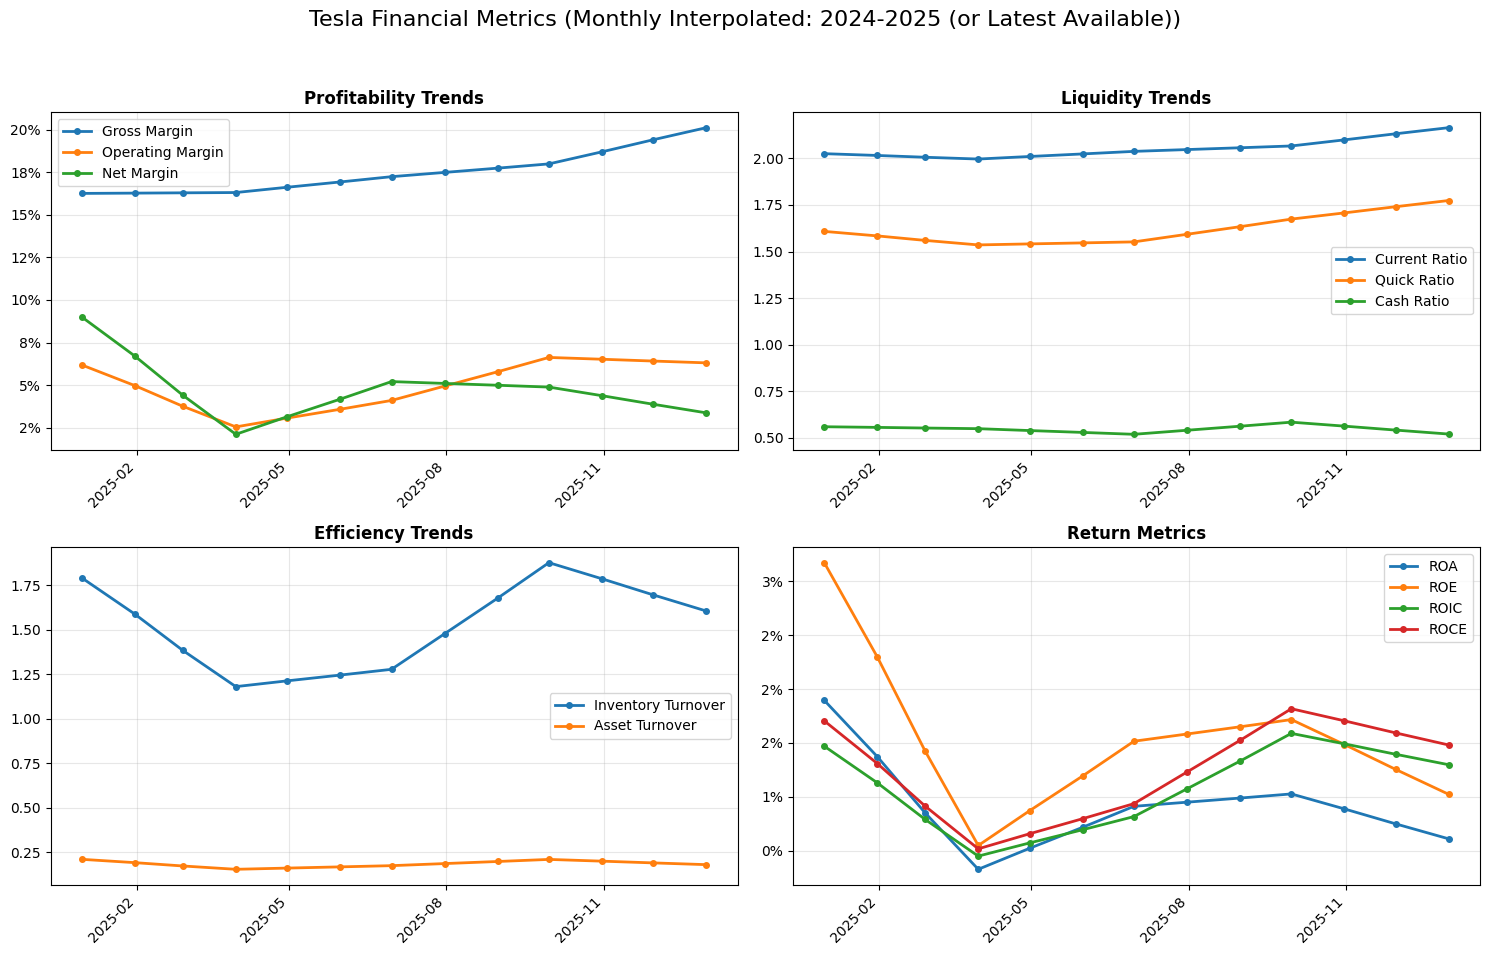

Visualization Complete.


In [10]:
# Call the pre-defined function
plot_trend()